In [1]:
## 0 ## : 필요 라이브러리 및 클래스 import
import time
import numpy as np
import random
from PIL import Image
from bldcsag1024_SD21 import *

/intern1/mmai04/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/intern1/mmai04/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/intern1/mmai04/.venv/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/intern1/mmai04/sd_inpaint_practice-main/BLDC/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.t

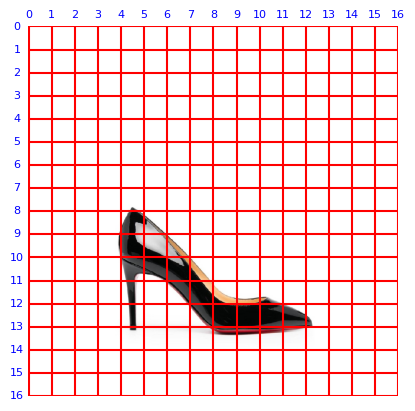

In [2]:
# - device는 SAM과 BLDCSAG768의 device를 다르게 설정해주세요.
SAM_device = 'cuda:1'
BLDCSAG_device = 'cuda:7'

## 1 ## Mask generation을 위한 coord 확인
# - x1 : 왼쪽 위 점의 x좌표
# - y1 : 왼쪽 위 점의 y좌표
# - x2 : 오른쪽 아래 점의 x좌표
# - y2 : 오른쪽 아래 점의 y좌표
# 자동으로 선택되지는 않고, 밑 SamHQImageProcessor에서 coord에 입력해주셔야합니다.
image_grid = ImageGrid('img.png')
image_grid.draw_grid()

In [3]:
## 2 ## : SAM으로 object mask 생성
# - Generation time : 3~7s / GPU Memory Usage : 6414MiB
# - input image를 BLDC 폴더 내에 'img.png'의 이름으로 저장해주세요.
# - image_path 이름 되도록이면 변경하지 말아주세요.
# - coord는 (x1, y1, x2, y2)로 값 순서를 반드시 지켜주세요. (Default: (2,2,14,14))
img_processor = SamHQImageProcessor(img_path="img.png", device = SAM_device, coord=(1, 1, 14, 14))
img_processor.run()

/intern1/mmai04/sd_inpaint_practice-main/BLDC/segment_anything/build_sam.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=device

<All keys matched successfully>


An error occurred while trying to fetch thibaud/controlnet-sd21-canny-diffusers: thibaud/controlnet-sd21-canny-diffusers does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


이미지가 output.png에 저장되었습니다.


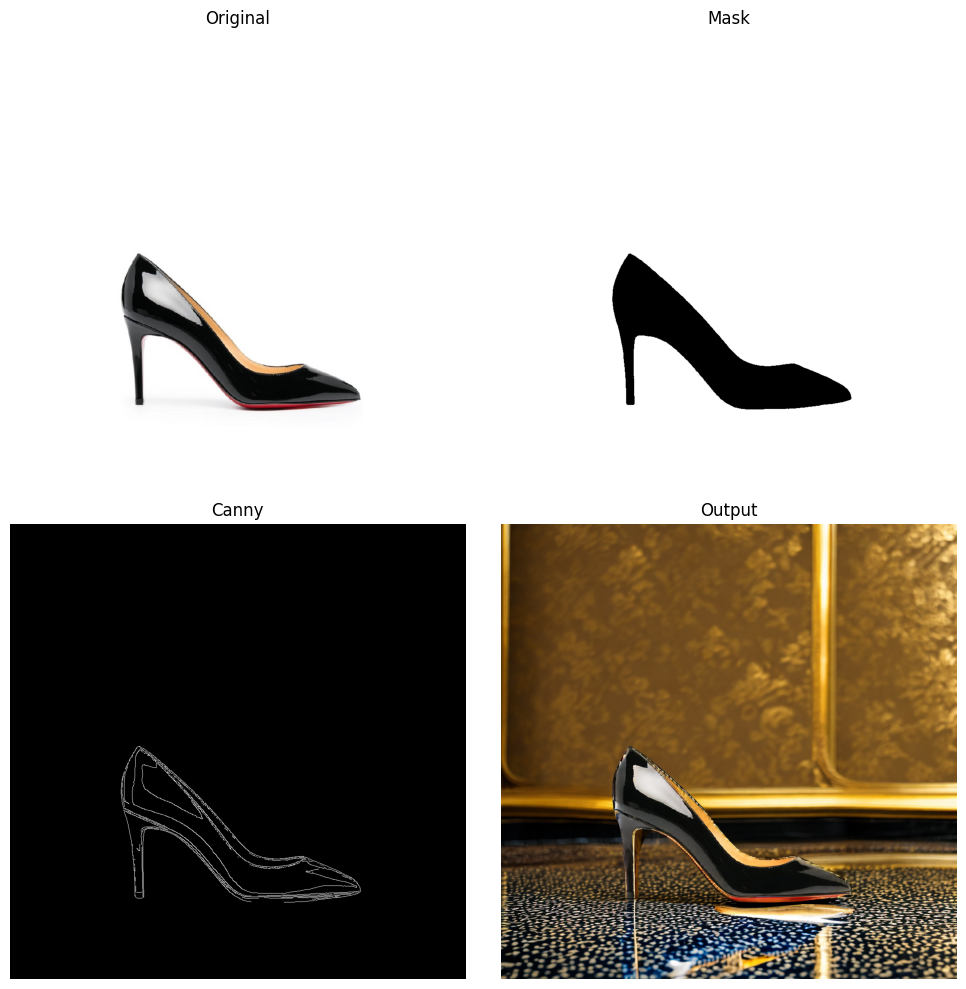

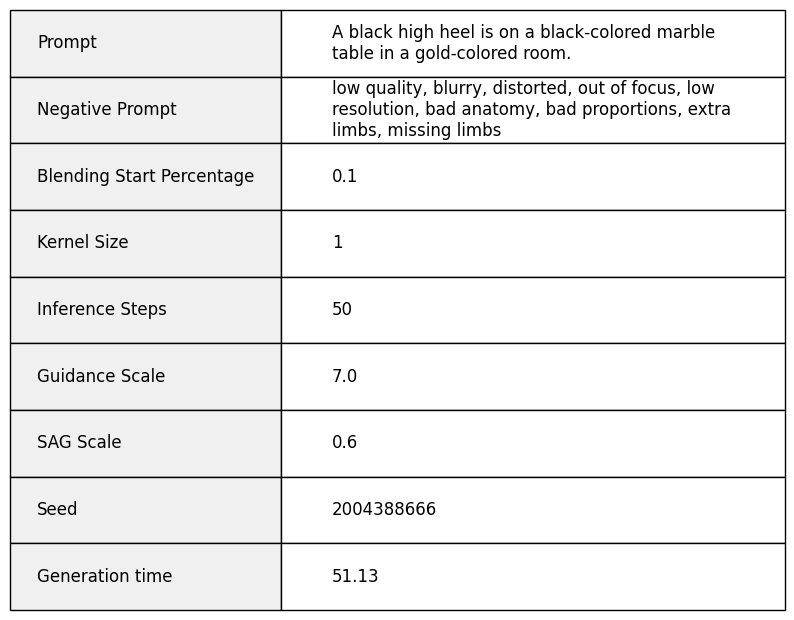

In [ ]:
## 3 ## : BLDCSAG1024로 output image 생성
# - Generation time : 75~85s(w/.SAG), 50~60s(w/o.SAG) / GPU Memory Usage : 8500~9500MiB
# - prompt와 negative_prompt는 자유롭게 변경하면서 사용해주세요.
# - output_col과 output_row는 output image의 개수와 출력 형태를 결정합니다.
# - blending_start_percentage에 따라 blending 과정을 얼마나 빠르게 시작할지 결정됩니다. (Default : 0.1, Recommend : [0.1,0.4])
# - kernel_size는 object outline에서 artifact 발견시 크기를 늘려주세요. (Default : 1, Recommend : [1,3]) 
# - num_inference_steps는 model이 inference 과정에서 진행할 sampling step입니다. (Default : 100, Recommend : [70,150])
# - guidance_scale는 prompt와 negative_prompt를 사용한 CFG Guidance scale 입니다. (Default : 7.0, Recommend : [7.0,7.5])
# - sag_scale은 SAG Guidance scale입니다. (Default : 0.6, Recommend : [0.6,0.8], SAG 미사용 시 0.0으로 설정해주시면 됩니다.)
# - seed는 None일 경우 random한 image가 generation됩니다.
                    
                    
parameters = {
    "prompt": "An image of Jack Daniels at a stylish rooftop bar in New York City at night, offering a breathtaking view of the city's iconic skyline.",
    "negative_prompt": "low quality, blurry, distorted, out of focus, low resolution, bad anatomy, bad proportions, extra limbs, missing limbs",
    "output_col": 1,
    "output_row": 1,
    "blending_start_percentage": 0.1,  
    "kernel_size": 1,                       # Default : 1
    "num_inference_steps": 50,              # Default : 50
    "guidance_scale": 7.0,                  # Default : 7.0
    "sag_scale": 0.6,                       # Default : 0.6
    "seed": 2004388666 #random.randint(1, 2147483647)   # Default : 0
}

start_time = time.time()
# - 주석처리된 부분은 참고용 input으로, 실제 input이 아니므로 주석해제하시면 오류 발생합니다.
bld_controlnet = BLDCSAG1024(
    prompt=parameters['prompt'],
    negative_prompt=parameters['negative_prompt'],
    # init_image='image.png',
    # mask='mask.png',
    # model_path='stabilityai/stable-diffusion-2-1',
    # controlnet_model_path='thibaud/controlnet-sd21-canny-diffusers',  # ControlNet SD 2.1 Canny model path
    blending_start_percentage = parameters['blending_start_percentage'],
    device = BLDCSAG_device,
    batch_size = parameters['output_col'] * parameters['output_row'],
    # output_path='output.png'
)
results = bld_controlnet.edit_image(
    kernel_size = parameters['kernel_size'], 
    num_inference_steps=parameters['num_inference_steps'],    
    guidance_scale=parameters['guidance_scale'],
    sag_scale = parameters['sag_scale'],             
    seed = parameters['seed'],
)
end_time = time.time()
elapsed_time = end_time - start_time
parameters['generation_time'] = elapsed_time
    
image_saver = ImageGridSaver(results, parameters['output_col'], parameters['output_row'], bld_controlnet.output_path)
image_saver.save_grid()

img_display = ImageGridDisplay('img.png', 'mask.png', 'canny.png', results[0])
img_display.display()

table = ParametersTable(parameters)
table.display_table()

# evaluator = ImageQualityEvaluator(output_path='output.png', mask_path='mask.png', original_path='image.png')
# evaluator.show_metrics_table()
    